In [1]:
import numpy as np
import pandas as pd 
import geopandas as gpd
import hvplot as hv
import hvplot.pandas
import sys, os
import pickle
import matplotlib.pyplot as plt
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))  # parent of notebooks
if project_root not in sys.path:
    sys.path.append(project_root)
    
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from src.util.model import eval_model, prep_data
seed = 42

In [2]:
# dff0 = pd.DataFrame()

# data_fp = "../../data/training_data"
# training_data = os.listdir(data_fp)
# for i in range(len(training_data)):
#     # if i > 4: 
#     #     break
#     fn = training_data[i]
#     df = pd.read_csv(os.path.join(data_fp, fn))
#     print(f"{fn} {df.shape}")
#     dff0 = pd.concat([dff0, df])
# print(dff0.shape)

dff0 = pd.read_csv("../../data/training_combined/training_combined_5.csv")
dff0['date'] = pd.to_datetime(dff0['date'])
dff0 = dff0[dff0['slope_angle'] > 0] # Removing flat slopes increases accuracy by about 6 percent

danger_levels = pd.read_csv("../../../data/FAC/FAC_Danger_rating_zone_elv.csv")
danger_levels['date'] = pd.to_datetime(danger_levels['date'])

coords_geodf = gpd.read_file("../../../data/FAC/zones/grid_coords_subset.geojson")

In [32]:
exclude_cols = ['date','id_x','slope_azi', 'danger_level','altitude','slope_angle','elevation_band','lat', 'lon', 'zone_name', 'geometry','danger_level.1']
# X, y, excluded_cols = prep_data(
#     dff0, 
#     danger_levels, 
#     coords_geodf,
#     replace_missing=True, 
#     change_danger=True,
#     exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 

# X = dff0.loc[:, ~dff0.columns.isin(exclude_cols)].copy(deep=True)
# y = dff0['danger_level']
# excluded_cols = dff0.loc[:, dff0.columns.isin(exclude_cols)].copy(deep=True)

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=seed, stratify=y)

train_set = dff0[dff0['date'] < pd.Timestamp(year=2024, month=10, day=1)]
test_set = dff0[dff0['date'] >= pd.Timestamp(year=2024, month=10, day=1)]

X_train = train_set.loc[:, ~train_set.columns.isin(exclude_cols)].copy()
X_test  = test_set.loc[:, ~test_set.columns.isin(exclude_cols)].copy()

y_train = train_set['danger_level']
y_test = test_set['danger_level']

In [33]:
# Params found from tuning
# {'class_weight': 'balanced', 
#  'max_depth': 50, 
#  'max_features': 0.5, 
#  'min_samples_leaf': 4, 
#  'min_samples_split': 20, 
#  'n_estimators': 1000}


rf = RandomForestClassifier(random_state=seed, n_jobs=-1,
                            max_depth=20,
                            max_features=0.5,
                            min_samples_leaf=4,
                            min_samples_split=20,
                            n_estimators=500,
                            class_weight='balanced'
                           )

In [15]:
cv = cross_val_score(rf, X_train,y_train,cv=5,n_jobs=-1)

In [16]:
for c in cv:
    print(f"{c * 100:.2f} ", end="")
print()
print(f"CV Results: Mean Accuracy - {cv.mean():.2f}% std - {cv.std():.2f}")

90.64 90.64 90.09 90.41 90.26 
CV Results: Mean Accuracy - 0.90% std - 0.00


In [34]:
rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'gini'
,max_depth,20
,min_samples_split,20
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,0.5
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


Train
Accuracy 0.99
Balanced Accuracy 0.99
MAE: 0.01361083984375
Test
Accuracy 0.58
Balanced Accuracy 0.42
MAE: 0.4500962000962001


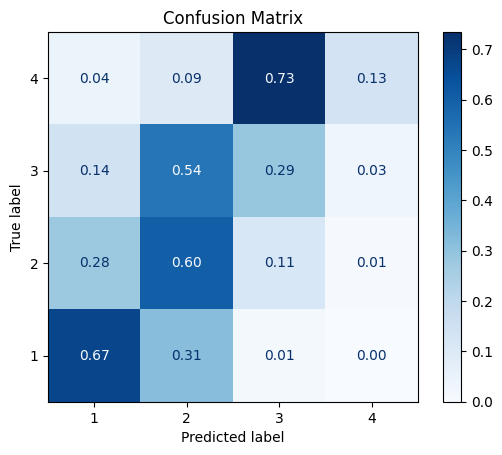

In [35]:
y_pred = rf.predict(X_test)

print("Train")
eval_model(y_train, rf.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)

/Users/nickclouse/Desktop/senior-proj/SPvenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2801: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Accuracy 0.40
Balanced Accuracy 0.40
MAE: 0.7673646209386281


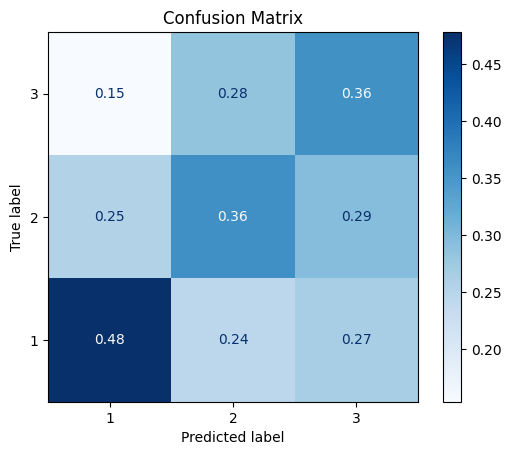

In [36]:
actual_dangers = pd.read_csv("../../data/2526_FAC/FAC_danger_levels_25.csv")

zone_map = {
    "whitefish range":"whitefish",
    "swan range":"swan",
    "flathead range & glacier np":"flathead"
}

actual_dangers['date'] = pd.to_datetime(actual_dangers['date'])
actual_dangers['zone_name'] = actual_dangers['zone_name'].apply(lambda x: zone_map[x])

curr_dff = pd.read_csv("../../data/ops25_26/new_all_predictions.csv").drop(columns=["predicted_danger"]).rename(columns={"date":"timestamp"})

val_x, val_y, val_excluded_cols = prep_data(
    curr_dff, 
    actual_dangers, 
    coords_geodf,
    replace_missing=True, 
    change_danger=True,
    exclude_cols=['date','id','id_x','slope_azi', 'danger_level','altitude','slope_angle','forecast_zone_id','elevation_band','lat', 'lon', 'zone_name', 'geometry']) 

eval_model(val_y, rf.predict(val_x), plot=True, norm=True)

In [37]:
rf.feature_names_in_

array(['Qs', 'Ql', 'Qg', 'TSG', 'Qg0', 'Qr', 'dIntEnergySnow',
       'meltFreezeEnergySnow', 'ColdContentSnow', 'OLWR', 'ILWR',
       'LWR_net', 'OSWR', 'ISWR', 'Qw', 'pAlbedo', 'mAlbedo', 'ISWR_h',
       'ISWR_dir', 'ISWR_diff', 'TA', 'TSS_mod', 'T_bottom', 'RH', 'VW',
       'VW_drift', 'DW', 'MS_Snow', 'HS_mod', 'HS_meas', 'hoar_size',
       'wind_trans24', 'HN3', 'HN6', 'HN12', 'HN24', 'HN72_24', 'PSUM24',
       'ski_pen', 'SWE', 'MS_Water', 'MS_Water_Soil', 'MS_Ice_Soil',
       'MS_Wind', 'MS_Rain', 'MS_SN_Runoff', 'MS_Surface_Mass_Flux',
       'MS_Sublimation', 'MS_Evap', 'Sclass1', 'Sclass2', 'zSd', 'Sd',
       'zSn', 'Sn', 'zSs', 'Ss', 'zS4', 'S4', 'zS5', 'S5'], dtype=object)

In [38]:
# dff0[exclude_cols].iloc[X_test.index]
# test_data = pd.concat([X_test,dff0[exclude_cols].loc[X_test.index]],axis=1)
test_data = pd.concat([X_test,excluded_cols.loc[X_test.index]],axis=1)
test_data['predicted'] = y_pred
test_data.head()

,Qs,Ql,Qg,TSG,Qg0,Qr,dIntEnergySnow,meltFreezeEnergySnow,ColdContentSnow,OLWR,...,slope_azi,date,altitude,lat,lon,zone_name,geometry,elevation_band,danger_level.1,predicted
886,58.670583,-15.545792,0.0,0.0,3.613875,0.0,-6.519500,-3.533000,-0.329875,276.302792,...,0.0,2024-12-03,1757.7,48.243116,-113.992494,swan,POINT (-113.99249394059275 48.24311604465016),middle,1,1
887,34.268375,-3.093750,0.0,0.0,4.861042,0.0,-6.192958,-4.065917,-0.439875,266.430250,...,0.0,2024-12-04,1757.7,48.243116,-113.992494,swan,POINT (-113.99249394059275 48.24311604465016),middle,1,1
888,35.801042,-5.193042,0.0,0.0,5.367292,0.0,-2.531792,-2.123750,-0.460792,266.439958,...,0.0,2024-12-05,1757.7,48.243116,-113.992494,swan,POINT (-113.99249394059275 48.24311604465016),middle,1,1
889,62.374875,-19.662708,0.0,0.0,4.999542,0.0,6.232750,-1.686542,-0.392625,275.602458,...,0.0,2024-12-06,1757.7,48.243116,-113.992494,swan,POINT (-113.99249394059275 48.24311604465016),middle,1,1
890,137.074750,-41.673750,0.0,0.0,3.310417,0.0,-3.116750,-1.099833,-0.296917,284.816792,...,0.0,2024-12-07,1757.7,48.243116,-113.992494,swan,POINT (-113.99249394059275 48.24311604465016),middle,2,2


In [39]:
feature_importances = pd.DataFrame(rf.feature_importances_,index = rf.feature_names_in_, columns=["importance"]).sort_values(by="importance", ascending=False)
print(feature_importances[feature_importances['importance'] > 0].index)

Index(['TA', 'ISWR_diff', 'ISWR_h', 'wind_trans24', 'OLWR', 'RH', 'TSS_mod',
       'mAlbedo', 'PSUM24', 'DW', 'HN72_24', 'ILWR', 'dIntEnergySnow',
       'VW_drift', 'VW', 'HN24', 'MS_Sublimation', 'Qg0', 'T_bottom',
       'LWR_net', 'TSG', 'HN12', 'HN3', 'SWE', 'HN6', 'MS_Snow', 'Ql', 'Qs',
       'pAlbedo', 'HS_mod', 'ski_pen', 'Sd', 'MS_Evap', 'MS_Rain', 'zSs',
       'ColdContentSnow', 'zSd', 'Qr', 'zS4', 'S4', 'meltFreezeEnergySnow',
       'Sn', 'zSn', 'MS_Water', 'Ss', 'ISWR', 'Qw', 'S5', 'OSWR', 'hoar_size',
       'ISWR_dir', 'Sclass2', 'MS_SN_Runoff', 'MS_Surface_Mass_Flux',
       'MS_Wind'],
      dtype='object')


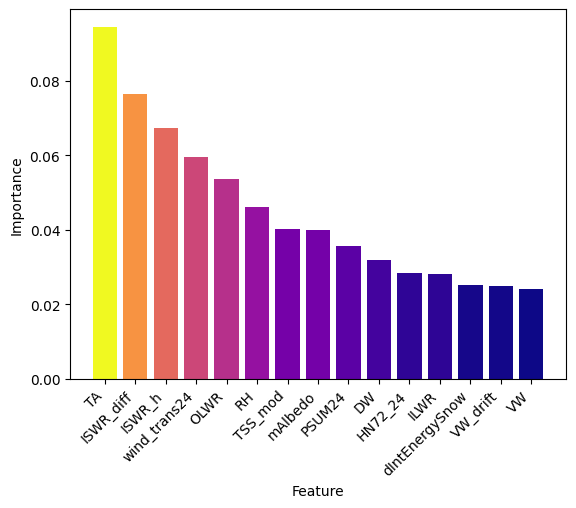

In [40]:
top = feature_importances.iloc[:15]
 
# Normalize and create colors
norm = plt.Normalize(top['importance'].min(), top['importance'].max())
cmap = plt.cm.plasma
colors = cmap(norm(top['importance']))

# Create figure and axes
fig, ax = plt.subplots()

bars = ax.bar(top.index, top['importance'], color=colors)

# Add colorbar — note the ax parameter
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])  # Required for colorbar
# fig.colorbar(sm, ax=ax, label='Importance')
plt.xticks(rotation=45, ha='right')
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.show()

Train
Accuracy 0.99
Balanced Accuracy 0.99
MAE: 0.01361083984375
Test
Accuracy 0.58
Balanced Accuracy 0.42
MAE: 0.4500962000962001


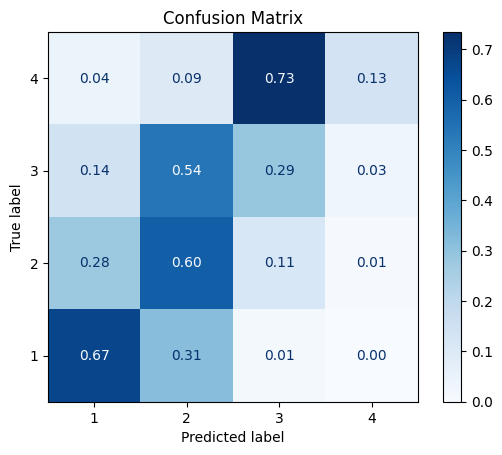

In [41]:

with open("../../data/models/best_model_4.pkl", "wb") as file:
    pickle.dump(rf, file)
    
with open("../../data/models/best_model_4.pkl", "rb") as file:
    best_model = pickle.load(file)
    
y_pred = best_model.predict(X_test)

print("Train")
eval_model(y_train, best_model.predict(X_train))

print("Test")
eval_model(y_test, y_pred, plot=True, norm=True)